In [1]:
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-11.8/
!export CUDA_DIR="/usr/local/cuda-11.8/"
!export TF_GPU_ALLOCATOR=cuda_malloc_async

In [2]:
import numpy as np
import tensorflow as tf

tf.config.threading.set_inter_op_parallelism_threads(0)
tf.config.threading.set_intra_op_parallelism_threads(0)
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8000)])
# tf.config.experimental.set_virtual_device_configuration(physical_devices[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
# for gpu in physical_devices:
#     tf.config.experimental.set_memory_growth(gpu, True)
# print("GPUS: {}".format(len(physical_devices)))

2022-11-09 21:13:53.018910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 21:13:53.106621: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 21:13:53.420913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/home/pedro/miniconda3/envs/ml2/lib/
2022-11-09 21:13:53.420958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libn

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
import time
import tensorflow_addons as tfa

layers = tf.keras.layers

from IPython import display

In [4]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
# !rm -rf ./logs

In [6]:
def normalize(image):
    a = (image - 127.5) 
    return a / 127.5

def denormalize(image):
    # return image
    return tf.cast(tf.cast(image, tf.float32) * 127.5 + 127.5, np.uint8)

In [7]:
import pathlib
import tensorflow as tf
import random

In [8]:
input_w = 720
input_h = 480

input_w = input_w / 2
input_h = input_h / 2

sub_scale = 1/2

# input_h = 672
# input_w = 976

# input_h *= 1.2
# input_w *= 1.2


# input_h = 576
# input_w = 864

hwfactor = input_h / input_w

input_h, input_w

BATCH_SIZE = 1

EPOCHS=1000
STEPS_PER_EPOCH = 900

In [9]:
input_h = int(input_h)
input_w = int(input_w)
input_h, input_w

(240, 360)

# Enlarge image

In [10]:
rf = 1
resize_factor = 1/rf # about 0.0833
resized_size_h = int(input_h * resize_factor)
resized_size_w = int(input_w * resize_factor)

print(resized_size_h, resized_size_h * rf, input_h)
assert resized_size_h * rf == input_h

print(resized_size_w, resized_size_w * rf, input_w)
assert resized_size_w * rf == input_w

240 240 240
360 360 360


## Generate and save random images

In [11]:
import os
import re

def image_generator(pictures = [], large_pictures = [], ds_pictures = [], return_ext=False):
    random.shuffle(pictures)
    def parse_name(filename):
        return "{}_" + re.sub(r"\.(png|jpeg|jpg)", r"_{}.\1", os.path.basename(filename))
    
    def format_name(name, subname):
        return name.format(random.randint(0, 1000), subname)
    def fn():
        input_w = 720
        input_h = 480
        for filename in pictures:
            fname = parse_name(filename)
            raw_png = tf.io.read_file(str(filename), name=filename)
            decoded_png_2 = tf.image.decode_png(raw_png, channels=3, name=filename)
            decoded_png_2 = tf.image.resize(decoded_png_2, [input_h, input_w],
                              method=tf.image.ResizeMethod.BILINEAR)

            yield decoded_png_2, format_name(fname, "original")
            yield tf.image.flip_left_right(decoded_png_2), format_name(fname, "flipped")

        for filename in ds_pictures:
            fname =  parse_name(filename)
            raw_png = tf.io.read_file(str(filename), name=filename)
            decoded_png = tf.image.decode_jpeg(raw_png, channels=3, name=filename)
            cropped = tf.image.resize_with_crop_or_pad(
              decoded_png,input_h ,input_w
            )
            yield cropped, format_name(fname, "original")
            yield tf.image.flip_left_right(cropped), format_name(fname, "center_crop")

            for i in range(200):
                cropped = tf.image.random_crop(
                  decoded_png, size=[input_h, input_w, 3])
                yield cropped, format_name(fname, "random_crop_"+str(i))
                yield tf.image.flip_left_right(cropped), format_name(fname, "random_crop_and_flip_"+str(i))

        for filename in large_pictures:
            fname =  parse_name(filename)
            raw_png = tf.io.read_file(str(filename), name=filename)
            decoded_png = tf.image.decode_jpeg(raw_png, channels=3, name=filename)
            cropped = tf.image.resize_with_crop_or_pad(
              decoded_png,input_h ,input_w
            )
            yield cropped, format_name(fname, "center_crop")

            for i in range(20):
                cropped = tf.image.random_crop(
                  decoded_png, size=[input_h, input_w, 3])
                yield cropped, format_name(fname, "random_crop_"+str(i))
            # yield tf.image.random_flip_left_right(cropped)
    return fn

In [12]:
from IPython.display import clear_output
from multiprocessing import Lock, Process, Queue, current_process, Value, Pool, cpu_count
from concurrent import futures

def cache_images():
    data_dir = pathlib.Path("./prepa")
    pictures = list(data_dir.glob('*.png'))

    # TODO: Remove filter
    pictures = random.sample(pictures, 1000)


    data_dir = pathlib.Path("./people")
    large_pictures = list(data_dir.glob('*.jpg'))


    data_dir = pathlib.Path("./ds_images")
    ds_pictures = list(data_dir.glob('*.jpg'))
    
    approx_size = len(pictures)*2 + len(ds_pictures)*2 + len(ds_pictures)*200*2 + len(large_pictures) + len(large_pictures)*20
    
    gen = image_generator(pictures, large_pictures, ds_pictures)
    
    
    print("starting")
    counter = Value('i', 0)
    
        
    it = iter(gen())
    con = True
    
    np = cpu_count()
    print(f'You have {np} cores')



    def f1(im, filename):
            im.numpy()
        #     input_w = 720
        # input_h = 480
            tf.keras.utils.save_img('./tmp/{}'.format(filename), im)
            with counter.get_lock():
                counter.value += 1

            if (counter.value % 10 == 0):
                clear_output(wait=True)
                print(f"{counter.value+1}/{approx_size}")   
            return f"{im.shape} {filename}"
    with futures.ThreadPoolExecutor(max_workers=min(int((np/3) * 2), 16)) as executor:    
        for im, filename  in it:
            # print(im.shape)
            assert (im.shape[0] == 480 and im.shape[1] == 720)
#             im, filename = next(it)
            future = executor.submit(f1, im, filename)
#             future.add_done_callback(lambda x: print(f"donee: {x}"))
        try:
            data = future.result()
        except Exception as exc:
            print('generated an exception: %s' % exc)
        else:
            print('%r page is' % data)
    

# cache_images()

## Load the cached images

In [13]:
import random

def image_generator_cached(size=None):
    data_dir = pathlib.Path("./tmp")
    # prepa_dir = pathlib.Path("./prepa")
    prepa_files = list(data_dir.glob('*.png'))
    random.shuffle(prepa_files)
    all_files = []
    for filename in prepa_files:
        all_files.append((filename, 'png'))
    for filename in list(data_dir.glob('*.jpg')):
        all_files.append((filename, 'jpg'))
    
    random.shuffle(all_files)
    if size:
        all_files = all_files[:size]
    
    def fn():
        for filename, img_type in all_files:
            raw_image = tf.io.read_file(str(filename), name=filename)
            if img_type == "png":
                yield tf.image.decode_png(raw_image, channels=3, name=filename)
            elif img_type == "jpg":
                yield tf.image.decode_jpeg(raw_image, channels=3, name=filename)
            
    return fn

In [14]:
image_count = len(list(pathlib.Path("./tmp").glob('*')))
print(f"image_count={image_count}")

fraction = int((STEPS_PER_EPOCH * EPOCHS) / image_count)
print(fraction)

dataset_size = int((STEPS_PER_EPOCH * EPOCHS) / (fraction + 1))
print(f"better dataset size: {dataset_size}")


image_count=13354
67
better dataset size: 13235


In [15]:
input_h, input_w

(240, 360)

In [16]:
downsize_image_ratio = 1/4


def make_dataset(size=None):
    load_large_images = image_generator_cached(size)

    train_ds = tf.data.Dataset.from_generator(load_large_images,  output_signature=
         tf.TensorSpec(shape=(int(input_h/sub_scale), int(input_w/sub_scale), 3), dtype=tf.float32))
            # .map(normalize)

    def resize_and_couple(images):
        images = normalize(images)
        images = tf.image.resize(images, (input_h, input_w))
        
        # cropped = tf.image.resize_with_crop_or_pad(
#               decoded_png,input_h ,input_w
#             )
        print(f"images.shape={images.shape}")
        if random.choices([True,False], weights=(0.3,0.7), k=1)[0] == True:
            return (images, images)
        
        # return (images,images)
        down = tf.image.resize(
            images,
            [int(resized_size_h * downsize_image_ratio), int(resized_size_w * downsize_image_ratio)],
            preserve_aspect_ratio=True,
            antialias=False,
            name=None)

        up = tf.image.resize(
            down,
            [resized_size_h, resized_size_w],
            preserve_aspect_ratio=True,
            antialias=False,
            name=None)
        
        

        return (images, up)

    # zipped_train_dataset = train_ds.interleave(
    #   lambda x: tf.data.Dataset.from_tensors(x).map(resize_and_couple, num_parallel_calls=tf.data.AUTOTUNE),
    #   cycle_length=4, num_parallel_calls=tf.data.AUTOTUNE,
    #   deterministic=False
    # )
    zipped_train_dataset = train_ds.map(resize_and_couple, num_parallel_calls=tf.data.AUTOTUNE)
    # Batch and shuffle the data
    return zipped_train_dataset
    # train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(1)

# lp_imgs = list(train_ds.shuffle(200).take(2))
train_ds = make_dataset(dataset_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2022-11-09 21:13:54.583374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 21:13:54.583752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 21:13:54.589104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 21:13:54.589324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 21:13:54.589534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

images.shape=(240, 360, 3)


In [17]:
def get_random_samples(size=2):
    return make_dataset(size)

In [18]:
resized_size_h

240

In [19]:
model_input_w = input_w
model_input_h = input_h

model_input_w, model_input_h

(360, 240)

In [20]:
resized_size_w, resized_size_h

(360, 240)

In [21]:
input_w, input_h

(360, 240)

In [22]:
def closest(stride, base_kernel, K):
    lst = list(range(0,base_kernel+stride, stride))
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

closest(2, 6, 5)

4

In [23]:
import math

def get_grid_size(x):
    col = int(math.sqrt(x))
    row = int(x / col)

    y = int(x - (col*row))
    row+=y

    return row, col

def get_bi_column(x, col=2):
    row = int(x / col)

    y = int(x - (col*row))
    row+=y

    return row, col

get_bi_column(9)

(5, 2)

In [24]:
import random

# Test Generator

In [25]:
def test_generator(generator, discriminator, autoencoder, size=2):
    # test_dataset = tf.data.Dataset.zip((train_ds, resized_ds))
    random_samples_ds = get_random_samples(size)
    test_data = random_samples_ds.batch(size)
    for images, resized_images in test_data:
        generated_images = generator(resized_images, training=False)
        encoded = autoencoder(images, training=False)

#         den_generated_images = denormalize(generated_images)

        imgs = zip(images, resized_images, encoded, generated_images)

        col, row = get_bi_column(size*4, 4)

        # print(f"col={col}, row={row}")

        fig = plt.figure(figsize=(row * 10, col * 7))

        def render_image(image, i):
            img = denormalize(image)
            plt.subplot(col, row, i+1)
            # im = np.copy(img)
            plt.imshow(tf.cast(img, np.uint8))
            plt.axis('off')

        i = 0
        for original, resize, enc, gener in imgs:
            render_image(original, i)
            render_image(resize, i+1)
            render_image(enc, i+2)
            render_image(gener, i+3)

        decision = discriminator(generated_images, training=False)
        print(f"Decision shape: {decision.shape}")
        print (f"Decision for the scaled images: {decision}")


    return generated_images

# Generator

In [26]:
import numpy as np

vgg19 = VGG19(
    include_top=False,
    weights='imagenet',
)
vgg19.trainable = False

# vgg19 = tf.keras.Model(
#     inputs=model.input,
#     outputs=model.output
# )


# model = VGG19(
#     include_top=False,
#     weights='imagenet',
# )
# model.trainable = False

def load_and_process_image(image_path):
    img = load_img(image_path)
    # convert image to array
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def deprocess(img):
    # perform the inverse of the pre processing step
    i = np.copy(img)
    i[:, :, 0] += 103.939
    i[:, :, 1] += 116.779
    i[:, :, 2] += 123.68
    # convert RGB to BGR
    i = i[:, :, ::-1]
 
    i = np.clip(i, 0, 255).astype('uint8')
    return i
 
 
def display_image(img):
    # remove one dimension if image has 4 dimension
    if len(img.shape) == 4:
        img = np.squeeze(img, axis=0)
 
    img = deprocess(img)
 
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return


# def get_content_model():
#     content_layer = 'block5_conv2'
#     content_model = tf.keras.Model(
#         inputs=model.input,
#         outputs=model.get_layer(content_layer).output
#     )
#     # content_model.summary()
#     return content_model

# c_model = get_content_model()

In [27]:
# 480 / 15, 720 / 22, 32 * 32
480 / 15, 704 / 22, 720 / 704


(32.0, 32.0, 1.0227272727272727)

In [28]:
# inx = 15
# iny = 22

# ex = 480
# ey = 720

# x * 15 = 480
# y * 22 = 720

# (x * 15) + (y * 22) = 480 + 720
# (x * 15) + (y * 22) - 480 - 720

In [29]:
480 / 30, 720 / 45

(16.0, 16.0)

In [30]:
# vgg19.summary()

In [31]:



# content_layer = 'block5_conv2'
# content_model = tf.keras.Model(
#     inputs=vgg19.input,
#     outputs=vgg19.get_layer(content_layer).output
# )
# style_layers = [
#     'block1_conv1',
#     'block3_conv1',
#     'block5_conv1'
# ]
# style_models = [tf.keras.Model(inputs=vgg19.input,
#                       outputs=vgg19.get_layer(layer).output) for layer in style_layers]


# def content_loss(content, generated):
#     a_C = content_model(content)
#     a_G = content_model(generated)
#     loss = tf.reduce_mean(tf.square(a_C - a_G))
#     return loss

# def gram_matrix(A):
#     channels = int(A.shape[-1])
#     a = tf.reshape(A, [-1, channels])
#     n = tf.shape(a)[0]
#     gram = tf.matmul(a, a, transpose_a=True)
#     return gram / tf.cast(n, tf.float32)
 
 
# weight_of_layer = 1. / len(style_models)
 
 
# # style loss
# def style_cost(style, generated):
#     J_style = 0
 
#     for style_model in style_models:
#         a_S = style_model(style)
#         a_G = style_model(generated)
#         GS = gram_matrix(a_S)
#         GG = gram_matrix(a_G)
#         current_cost = tf.reduce_mean(tf.square(GS - GG))
#         J_style += current_cost * weight_of_layer
 
#     return J_style

# opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# a=1
# b=100
# @tf.function
# def train_step(images, generated, iterations=50):
#     with tf.GradientTape() as tape:
#         J_content = content_loss(images, generated)
#         J_style = style_cost(images, generated)
#         J_total = a * J_content + b * J_style

#     grads = tape.gradient(J_total, generated)
#     opt.apply_gradients([(grads, generated)])

#     return generated, J_total

# # layers.Input()
        

# for d in get_random_samples(1).take(1).batch(1):
#     images, resized  = d

#     best_cost = 9e13
#     best_image = None
#     rresized = tf.Variable(tf.identity(resized), trainable=True, dtype=tf.float32)
#     plt.figure()
#     display_image(images)
#     for i in range(100):
#         generated, cost = train_step(images, rresized)
#         best_cost = tf.math.minimum(best_cost, cost)
#         if best_cost == cost:
#             best_image = tf.identity(generated)
#             plt.figure()
#             display_image(best_image)
#         if i % 10 == 0:
#             print("Iteration :{}".format(i))
#             print('Total Loss {:e}.'.format(cost))
#     display_image(best_image)

In [32]:
# content_path = "tmp/0_159-Pre-registro-bachillerato_1_random_crop_168.jpg"
# content_img = load_and_process_image(content_path)
# display_image(content_img)

content_model = tf.keras.Model(
    inputs=vgg19.input,
    outputs=vgg19.get_layer("block4_conv4").output
)
content_model.trainable = False

def content_loss(content, generated):
    a_C = content_model(preprocess_input(content))
    a_G = content_model(preprocess_input(generated))
    loss = tf.reduce_mean(tf.square(a_C - a_G))
    return loss

In [33]:
def make_kernel(s):
        return closest(min(2,s), s, s*hwfactor), s

# init_fn = tf.keras.initializers.LecunUniform(seed=123)
# init_fn = tf.keras.initializers.GlorotNormal()

def residual_block(block_input, filters=64, momentum=0.8):
#     x = layers.Conv2D(filters, kernel_size=3, padding='same', kernel_initializer=init_fn)(block_input)
    x = tfa.layers.SpectralNormalization(
        layers.Conv2D(filters, kernel_size=3, padding='same'))(block_input)
#     x = tfa.layers.SpectralNormalization(
#         layers.Conv2D(filters, kernel_size=3, padding='same', kernel_initializer=init_fn))(block_input)
#     x = layers.BatchNormalization(momentum=momentum)(x)

    x = layers.PReLU(shared_axes=[1, 2])(x)
#     x = tfa.layers.SpectralNormalization(
#         layers.Conv2D(filters, kernel_size=3, padding='same', kernel_initializer=init_fn))(x)
    x = tfa.layers.SpectralNormalization(
        layers.Conv2D(filters, kernel_size=3, padding='same'))(x)
#     x = layers.Conv2D(filters, kernel_size=3, padding='same', kernel_initializer=init_fn)(x)
#     x = layers.BatchNormalization(momentum=momentum)(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    x = layers.Add()([block_input,x]) 
#     x = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True, 
#                                          beta_initializer="random_uniform", gamma_initializer="random_uniform")(x)
#     x = tfa.layers.GroupNormalization(groups=8, axis=3)(x)
#     x = layers.BatchNormalization()(x)
    return x

def pixel_shuffle(x, channels, downsampleFactor, momentum=0.8):
    if downsampleFactor == 1:
#         x = layers.Conv2D(channels * (downsampleFactor ** 2), 3, padding="same",
#                activation="relu", kernel_initializer="Orthogonal",
#                          strides=2)(x)
#         x = layers.BatchNormalization(momentum=momentum)(x)
        x = tfa.layers.SpectralNormalization(
            layers.Conv2D(channels * 2, 3, padding="same",
               activation="leaky_relu", kernel_initializer="Orthogonal",
                         strides=2))(x)
        outputs = tf.nn.depth_to_space(x, 2)
    else:
        x = tfa.layers.SpectralNormalization(
            layers.Conv2D(channels * (downsampleFactor * 2), 3, padding="same",
               activation="relu", kernel_initializer="Orthogonal"))(x)
#         x = layers.Conv2D(channels * (downsampleFactor ** 2), 3, padding="same",
#                activation="relu", kernel_initializer="Orthogonal")(x)
#         x = layers.BatchNormalization(momentum=momentum)(x)
        outputs = tf.nn.depth_to_space(x, downsampleFactor)
    
    return outputs

def upscale_block(block_input, filters=64, scale=1):
# def upscale_block(block_input, filters=128, scale=1):
#     x = layers.Conv2D(filters, kernel_size=3, padding='same', kernel_initializer=init_fn)(block_input)
    x = tfa.layers.SpectralNormalization(
        layers.Conv2D(filters, kernel_size=3, padding='same'))(block_input)
#     x = layers.BatchNormalization()(x)
    x = pixel_shuffle(x, filters, 1)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    return x


def pixel_shuffle2(channels, downsampleFactor, momentum=0.8):
    ups = tfa.layers.SpectralNormalization(
            layers.Conv2D(channels * (downsampleFactor * 2), 3, padding="same",
               activation="relu", kernel_initializer="Orthogonal"))
    @tf.function
    def fn(x):
        x = ups(x)
        return tf.nn.depth_to_space(x, downsampleFactor)
    return fn

def upscale_block2(filters=64, scale=1):
    conv = tfa.layers.SpectralNormalization(
            layers.Conv2D(filters, kernel_size=3, padding='same'))
    shuffle = pixel_shuffle2(filters, scale)
    act = layers.PReLU(shared_axes=[1, 2])
    
    @tf.function
    def fn(block_input):
    # def upscale_block(block_input, filters=128, scale=1):
    #     x = layers.Conv2D(filters, kernel_size=3, padding='same', kernel_initializer=init_fn)(block_input)
        x = conv(block_input)
    #     x = layers.BatchNormalization()(x)
        x = shuffle(x)
        x = act(x)
        return x
    return fn


gen_vgg19 = model = tf.keras.Model(
    inputs=vgg19.input,
    outputs=vgg19.get_layer("block4_conv4").output
)
model.trainable = False


class AttentionLayer(tf.keras.layers.Layer):
  def __init__(self, filters, activation=False):
    super(AttentionLayer, self).__init__()
    self.filters = filters
    self.activation = activation
    
  def build(self, input_shape):
    self.in_shape = input_shape
    b, hi, wi, c = input_shape
    self.downscale1 = layers.Conv2D(tf.cast(c*4, tf.int32), 4, strides = 4)
    self.downscale2 = layers.Conv2D(tf.cast(c*2, tf.int32), 2, strides = 2)
    self.fc = self._conv(self.filters)
    self.gc = self._conv(self.filters)
    self.hc = self._conv(self.filters)
    self.xc = self._conv(self.filters)
#     self.upscale1 = upscale_block2(filters=self.filters, scale=4)
#     self.upscale2 = upscale_block2(filters=self.filters, scale=2)
    self.upscale1 = layers.UpSampling2D((4,4), interpolation='bilinear')
    self.upscale2 = layers.UpSampling2D((2,2), interpolation='bilinear')

    self.gamma = tf.Variable([1.], name="gamma")
    self.act = layers.LeakyReLU()
#     self.downsized_dims = tf.cast(hi/6, tf.int32), tf.cast(wi/6, tf.int32), c*6
    
  def _conv(self, filters, kernel=1, strides=1):
    return layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False)
    
  def call(self, inputs):
    ch = self.filters
    xdsh = self.in_shape
    b = xdsh[0]
    hi = xdsh[1]
    wi = xdsh[2]
    c = xdsh[3]
        
#     print(f"shape:{[b, hi, wi, c]}")
    xd = self.downscale1(inputs)
    xd = self.downscale2(xd)

#     b, hi, wi, c = b, tf.cast(hi/6, tf.int32), tf.cast(wi/6, tf.int32), c*6
    xdsh = tf.shape(xd)
    b = xdsh[0]
    hi = xdsh[1]
    wi = xdsh[2]
    c = xdsh[3]

#     print(x.shape)
    f = self.fc(xd) # [bs, h, w, c']
    g = self.gc(xd) # [bs, h, w, c']
    h = self.hc(xd) # [bs, h, w, c]
    inputs = self.xc(inputs)
    
#     print(f"f={f.shape}")
#     print(f"g={g.shape}")

    f = tf.reshape(f, [-1, hi*wi, ch])
    g = tf.reshape(g, [-1, hi*wi, ch])
    h = tf.reshape(h, [-1, hi*wi, ch])
#     print(f"f={f.shape}")
#     print(f"g={g.shape}")
#     print(f"g={g.shape}, f={f.shape}")

    s = tf.matmul(g, f, transpose_b=True) # # [bs, N, N]

    #     print(f"s={s.shape}")

    beta = tf.nn.softmax(s)  # attention map

#     print(f"beta={beta.shape}, h={h.shape}")

    o = tf.matmul(beta, h) # [bs, N, C]

#     print(f"gamma={self.gamma}, o={o.shape} x={x.shape}")
    
    o = tf.reshape(o, shape=[b, hi, wi, tf.cast(ch, tf.int32)])
    o = self.upscale1(o)
    o = self.upscale2(o)
    
#     print(f"Reshaped o={o.shape}")
#     print(f"gamma={self.gamma}, o={o.shape} inputs={inputs.shape}")

    x = self.gamma * o + inputs

    if self.activation:
        x = self.act(x)

    return x

def get_conv(filters):
    conv = tf.keras.Sequential()
    conv.add(tfa.layers.SpectralNormalization(
        layers.Conv2D(filters, 3, padding="same", use_bias=False)
    ))
    conv.add(layers.LeakyReLU())
    return conv

def get_encoder():
    encoder = tf.keras.Sequential(name="encoder")
    encoder.add(layers.GaussianDropout(0.2))
    encoder.add(get_conv(1024))
    encoder.add(layers.MaxPooling2D(pool_size = (2, 2), padding='same'))
    encoder.add(get_conv(512))
    encoder.add(layers.MaxPooling2D(pool_size = (2, 2), padding='same'))
    encoder.add(get_conv(256))
    encoder.add(layers.MaxPooling2D(pool_size = (2, 2), padding='same'))
    encoder.add(get_conv(128))
    encoder.add(layers.MaxPooling2D(pool_size = (3, 3), padding='same'))
    return encoder

def get_decoder():
    decoder = tf.keras.Sequential(name="decoder")
    decoder.add(layers.UpSampling2D((3, 3), interpolation='bilinear'))
    decoder.add(get_conv(512))
    decoder.add(layers.UpSampling2D((2, 2), interpolation='bilinear'))
    decoder.add(get_conv(256))
    decoder.add(layers.UpSampling2D((2, 2), interpolation='bilinear'))
    decoder.add(get_conv(128))
    decoder.add(layers.UpSampling2D((2, 2), interpolation='bilinear'))
    decoder.add(get_conv(64))
    return decoder
    

class AutoEncoder(tf.keras.Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    
  def build(self, input_shape):
    self.encoder = get_encoder()
    self.decoder = get_decoder()
    
    self.encoder.build(input_shape=input_shape)
    
    sh = self.encoder.output_shape
    
    self.flatten = layers.Flatten()
    self.seq1 = layers.Dense(1024)
    self.reshape = layers.Reshape([sh[1], sh[2], sh[3]])
    
    self.last = layers.Conv2D(3, 3, padding='same', activation='tanh')
    self.inputs_dropout = layers.Dropout(0.2)

    
  def call(self, inputs):
    x = self.inputs_dropout(inputs)
    x = self.encoder(x)
    x = self.flatten(x)
    x = self.reshape(x)
    x = self.decoder(x)
    
    # x_inputs = self.conv_input(inputs)
    
    # x = self.add([x * self.gamma, x_inputs])
    # x = self.attention(x)
    x = self.last(x)
    return x


class Generator(tf.keras.Model):
  def __init__(self, autoencoder):
    super(Generator, self).__init__()
    self.conv_input = get_conv(64)
    self.conv_auto = get_conv(64)
    self.gamma = tf.Variable([1.], name="gamma")
    self.add = layers.Add()
    self.last = layers.Conv2D(3, 3, padding='same', activation='tanh')
    self.attention = AttentionLayer(64, activation=True)
    self.autoencoder = autoencoder
    self.last = layers.Conv2D(3, 3, padding='same', activation='tanh')

    
  def call(self, inputs):
    x_inputs = self.conv_input(inputs)
    x = self.autoencoder(inputs)

    x = self.conv_auto(x)
    
    x = self.add([x * self.gamma, x_inputs])
    x = self.attention(x)
    return self.last(x)

def make_sgenerator_model(scale=8, num_filters=64, autoencoder=None):
    return Generator(autoencoder)

# test_model = make_sgenerator_model()

# test_model.build(input_shape=[2, input_h, input_w, 64])

# prepa_dir = pathlib.Path("./prepa")
# prepa_files = list(prepa_dir.glob('*.png'))

# # # i = 0
# # # ch = 16
# content_img = load_and_process_image(prepa_files[0])
# x = content_img

# # layers.Conv2D(ch, 1, strides=1, padding="same", use_bias=False)(x)
# generator = make_sgenerator_model()
# generator(x)

# Discriminator

In [34]:
def disc_bloc(filters, strides, name):
    model = tf.keras.Sequential(name=name)
    model.add(tfa.layers.SpectralNormalization(
        layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')))
    model.add(layers.LeakyReLU())
    return model


# vgg19.get_layer("block4_conv4").output
disc_vgg19 = model = tf.keras.Model(
    inputs=vgg19.get_layer("block4_pool").input,
    outputs=vgg19.output
)
model.trainable = False

def make_discriminator_model():
    model = tf.keras.Sequential(name="discriminator")
    # tf.cast(image * 127.5 + 127.5, np.uint8)
#     model.add(layers.Lambda(lambda x: preprocess_input(x)))
#     model.add(gen_vgg19)
#     model.add(disc_vgg19)
#     model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Dense(1))

#     model = tf.keras.Sequential()
    filters = 64
    model.add(
        layers.Conv2D(filters, kernel_size=3, padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(disc_bloc(filters, 2, name="disc_bloc_1"))
#     model.add(disc_bloc(filters*2, 1))
    model.add(disc_bloc(filters*2, 2, name="disc_bloc_2"))
#     model.add(disc_bloc(filters*4, 1))
    model.add(disc_bloc(filters*4, 2, name="disc_bloc_3"))
#     model.add(disc_bloc(filters*8, 1))
    model.add(disc_bloc(filters*8, 2, name="disc_bloc_4"))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU())
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model



In [35]:
discriminator = make_discriminator_model()
# discriminator_downsized = make_discriminator_model()
autoencoder = AutoEncoder()
generator = make_sgenerator_model(autoencoder=autoencoder)

# discriminator.build(input_shape=[2, input_h, input_w, 3])
# print(discriminator.output_shape)

images.shape=(240, 360, 3)


2022-11-09 21:13:56.346371: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-09 21:13:57.934393: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Decision shape: (3, 1)
Decision for the scaled images: [[-0.00012914]
 [ 0.00076038]
 [-0.00148904]]


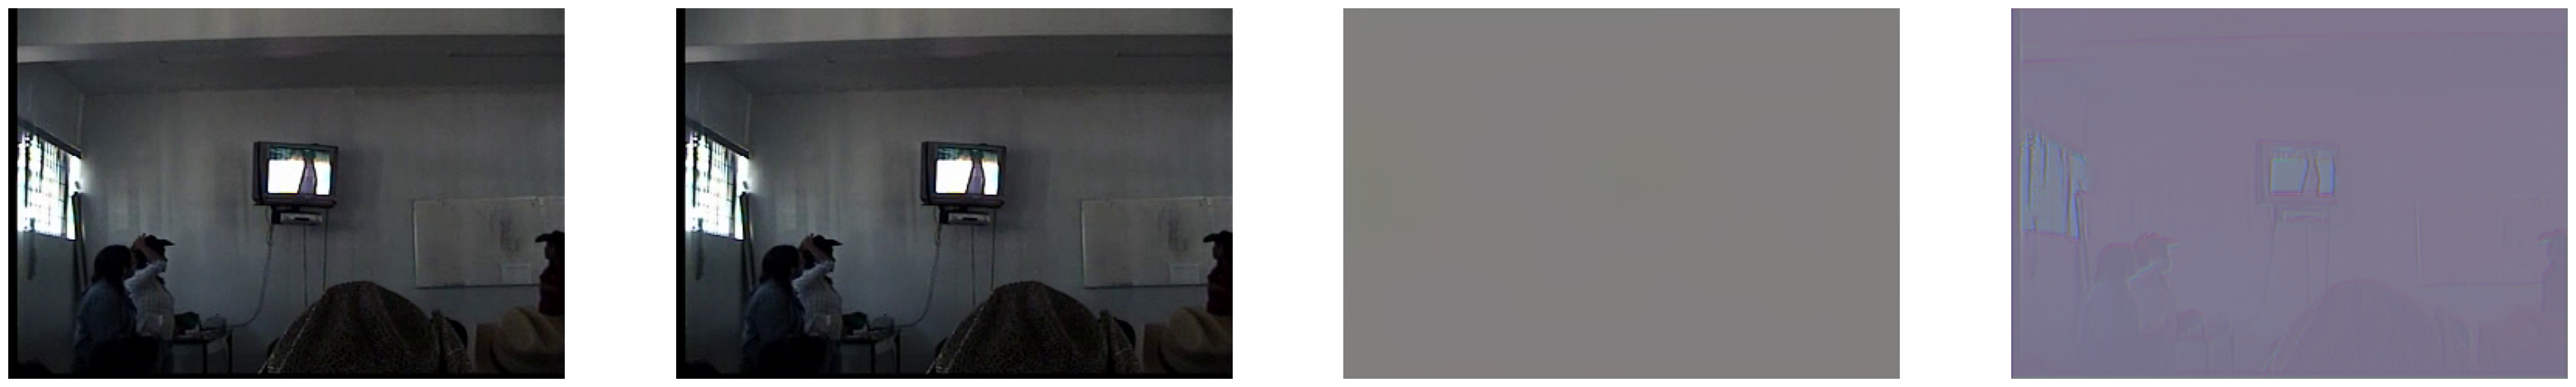

In [36]:
_ = test_generator(generator, discriminator, autoencoder, 3)

# Losses

In [37]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [38]:
# def discriminator_downsized_loss(fake_output, is_downsized=True):
#     if is_downsized:
#         return cross_entropy(tf.ones_like(fake_output), fake_output)
#     else:
#         return cross_entropy(tf.zeros_like(fake_output), fake_output)

In [39]:
def ssim_loss(real, fake):
        real = denormalize(real)
        fake = denormalize(fake)
        ssim = tf.math.reduce_sum(tf.image.ssim(real, fake, 255.0))
        ms_ssim = tf.math.reduce_sum(tf.image.ssim_multiscale(real, fake, 255.0))
        same_ms_ssim = tf.math.reduce_sum(tf.image.ssim_multiscale(real, real, 255.0))
        
        ssim_loss =  1 * (same_ms_ssim - ssim)
        ms_ssim_loss = 1 *  (same_ms_ssim - ms_ssim)
        return ssim_loss + ms_ssim_loss

In [40]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [41]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [42]:
mse = tf.keras.losses.MeanSquaredError()
def autoencoder_loss(real_output, fake_output):
    return mse(real_output, fake_output) + ssim_loss(real_output, fake_output)

In [43]:
# def generator_downsized_loss(fake_output, is_downsized=True):
#     if is_downsized:
#         return cross_entropy(tf.zeros_like(fake_output), fake_output)
#     else:
#         return cross_entropy(tf.ones_like(fake_output), fake_output)

In [44]:
# Optimizers

In [45]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# Metrics

In [46]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = f'logs/gan/train/{current_time}'
train_log_dir

'logs/gan/train/20221109-211358'

In [47]:
def generate_and_save_images(generator, discriminator, autoencoder, epoch, save=True): 
    predictions = test_generator(generator, discriminator, autoencoder, 3)
    if save == True:
        plt.savefig('./gan_output/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# generate_and_save_images(generator, discriminator, 0, False)

In [48]:
# import signal
# import sys

# def sigint_handler(signal, frame):
#     print ('KeyboardInterrupt is caught')
#     checkpoint.save(file_prefix = checkpoint_prefix)
#     sys.exit(0)
# signal.signal(signal.SIGINT, sigint_handler)

# Optimizer

In [49]:
# lrgen=tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[1000, 10000], values=[0.1, 1e-4, 1e-5])
# lrdist=tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[1000, 10000], values=[1e-3, 1e-4, 1e-5])

auto_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00004, beta_1=0.5)
# discriminator_down_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5)

# Checkpoints

In [50]:
checkpoint_dir = './gan_autoencoder_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
#                                  discriminator_down_optimizer=discriminator_down_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
#                                 discriminator_downsized=discriminator_downsized
                                )
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

In [51]:
# try:
#     if ckpt_manager.latest_checkpoint:
#         checkpoint.restore(ckpt_manager.latest_checkpoint)
# except:
#     print("Could not restore the checkopint")

In [52]:
# gpus = tf.config.list_logical_devices('GPU')

# with tf.device(gpus[0].name):

class GANModel(tf.keras.Model):
  def __init__(self, gen, disc):
    super(GANModel, self).__init__(name="GANModel")
    self.generator = gen
    self.discriminator = disc

  def train_step(self, all_images):
    images, resized = all_images
    with tf.GradientTape() as auto_tape, tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(resized, training=True)
    
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        _gen_loss = gen_loss
        mse = content_loss(images, generated_images)
        gen_loss+=mse
        
        disc_loss = discriminator_loss(real_output, fake_output)
        
        encoded = autoencoder(images, training=True)
        auto_loss = autoencoder_loss(images, encoded)

#         images = tf.cast(images, tf.float32)
        #         # avoid too large errors
#         real_output = tf.clip_by_value(real_output, 0.0, 255.0)
#         fake_output = tf.clip_by_value(fake_output, 0.0, 255.0)
        
#         dimages = denormalize(images)
# #         dresized = denormalize(resized)
#         dgenerated_images = denormalize(generated_images)
#         ssim = tf.math.reduce_sum(tf.image.ssim(dimages, dgenerated_images, 255.0))
#         ms_ssim = tf.math.reduce_sum(tf.image.ssim_multiscale(dimages, dgenerated_images, 255.0))
#         same_ms_ssim = tf.math.reduce_sum(tf.image.ssim_multiscale(dimages, dimages, 255.0))
#         resized_ms_ssim = tf.math.reduce_sum(tf.image.ssim_multiscale(dimages, dresized, 255.0))
        
#         downsized_output = discriminator_downsized(generated_images, training=True)
#         disc_loss_down = tf.cond(same_ms_ssim == resized_ms_ssim,
#                                     lambda: discriminator_downsized_loss(downsized_output, True),
#                                  lambda: discriminator_downsized_loss(downsized_output, False))
#         gen_loss += tf.cond(same_ms_ssim == resized_ms_ssim,
#                                     lambda: generator_downsized_loss(downsized_output, True),
#                                  lambda: generator_downsized_loss(downsized_output, False))

#         ssim_loss =  1 * (same_ms_ssim - ssim)
#         ms_ssim_loss = 1 *  (same_ms_ssim - ms_ssim)
#         ssim_losses =  ssim_loss + ms_ssim_loss
#         gen_loss += ssim_losses
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_autoencoder = auto_tape.gradient(auto_loss, autoencoder.trainable_variables)
# #     gradients_of_discriminator_down = disc_tape2.gradient(disc_loss_down, discriminator_downsized.trainable_variables)
    
#     gradients_of_generator, _ = tf.clip_by_global_norm(gradients_of_generator, 5.0)
#     gradients_of_discriminator, _ = tf.clip_by_global_norm(gradients_of_discriminator, 5.0)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    auto_optimizer.apply_gradients(zip(gradients_of_autoencoder, autoencoder.trainable_variables))
#     discriminator_down_optimizer.apply_gradients(zip(gradients_of_discriminator_down, discriminator_downsized.trainable_variables))

    return {"gen_loss": gen_loss, "disc_loss":disc_loss, "auto_loss":auto_loss
#             "_gen_loss": _gen_loss,
#             "mse":mse,
#             "ssim_loss":ssim_loss, "ms_ssim_loss":ms_ssim_loss, 
#             "ssim":ssim, "ms_ssim":ms_ssim, "same_ms_ssim":same_ms_ssim
           }


In [53]:
# %tensorboard --logdir logs/gradient_tape

# Train Loop

In [54]:
def on_epoch_end(epoch, logs=None):
    pass
#     clear_output(wait=True)
#     generate_and_save_images(generator, discriminator,
#                     epoch + 1)
#     ckpt_save_path = ckpt_manager.save()
#     print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
#                                                                 ckpt_save_path))
def on_batch_end(batch, logs):
    if batch % 99 == 0 and batch > 0:
        if "gen_loss" in logs:
            
            tf.summary.scalar('batch_gen_loss', tf.constant(logs["gen_loss"], tf.float16), step=batch*BATCH_SIZE)
            tf.summary.scalar('batch_disc_loss', tf.constant(logs["disc_loss"], tf.float16), step=batch*BATCH_SIZE)
            # tf.summary.scalar('ms_ssim', logs["ms_ssim"], step=batch*BATCH_SIZE)
        clear_output(wait=True)
        print("Logs:")
        print(logs)
        generate_and_save_images(generator, discriminator, autoencoder,
                        batch + 1)
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for batch {} at {}'.format(batch+1,
                                                                    ckpt_save_path))
                                                        
lm = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end, on_batch_end=on_batch_end)


tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = train_log_dir,
      write_graph=True, # visualize the graph
     histogram_freq = 1, update_freq=100,
#      profile_batch = (1,200)
                                                )

# train(train_ds, EPOCHS)
model = GANModel(generator, discriminator)
model.compile(metrics=["gen_loss", "disc_loss"])
# model.compile(metrics=["gen_loss", "disc_loss", "ms_ssim", "ms"], run_eagerly=True)
model.fit(
    train_ds.repeat(),
    epochs=EPOCHS,
    callbacks=[tboard_callback, lm],
    steps_per_epoch=STEPS_PER_EPOCH,
#     steps_per_epoch=int(image_count/BATCH_SIZE),
    workers=3)


Epoch 1/1000


KeyboardInterrupt: 

In [ ]:
def change_model(model, new_input_shape=(None, 40, 40, 3)):
    # replace input shape of first layer
    # model.layers[1].batch_input_shape = new_input_shape
    # input_layer = layers.InputLayer(input_shape=new_input_shape, name="input_1")
    # model.input = input_layer

    new_model = make_sgenerator_model(new_input_shape)

    # feel free to modify additional parameters of other layers, for example...
    # model._layers[2].pool_size = (8, 8)
    # model._layers[2].strides = (8, 8)

    # rebuild model architecture by exporting and importing via json
    # new_model = keras.models.model_from_json(model.to_json())
    new_model.summary()

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    # test new model on a random input image

    return new_model

In [ ]:
checkpoint_path = checkpoint_dir+"/weights/weights-{epoch:04d}.ckpt"

generator.save_weights(checkpoint_path.format(epoch=0))
discriminator.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
save_path = "./weights/gan/2/{}/"

gen_path = os.path.join(save_path.format("generator"))
tf.saved_model.save(generator, gen_path)
disc_path = os.path.join(save_path.format("discriminator"))
tf.saved_model.save(discriminator, disc_path)


In [ ]:
loaded_generator = tf.saved_model.load(gen_path)
loaded_discriminator = tf.saved_model.load(disc_path)

In [ ]:
generate_and_save_images(loaded_generator, loaded_discriminator,
                             9999)